### Natural Language Processing with Disaster Tweets
This kaggle competition focuses on leveraging Twitter as a critical communication channel during emergencies. With the widespread use of smartphones, people are increasingly sharing real-time observations of disasters. This presents a valuable opportunity for organizations like disaster relief and news agencies to programmatically monitor Twitter for crucial information. However, the core challenge lies in accurately identifying tweets that genuinely announce a disaster amidst the vast amount of less relevant information.

In [11]:
import os
os.environ['TF_USE_LEGACY_KERAS']='1'
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization

Available data contains columns keyword, location, tweet text and boolean label indicating whether the tweet is about a disaster or not. There are total 7613 tweets

In [12]:
raw_data = pd.read_csv("data/train.csv")
raw_data.shape

(7613, 5)

In [13]:
raw_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Exploratory Data Analysis
Location column has 33% missing data while column keyword has 0.80% missing data.<br>
I have not considered these two columns in classification.

In [14]:
raw_data.isna().sum()*100/raw_data.shape[0]

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

##### Potential cleaning strategies
- removing hyperlinks
- removing "#"

In [24]:
## any pre-processing like removing hyperlinks
def remove_links_from_list(text_list: list[str]) -> list[str]:
    """
    Removes HTTP/HTTPS links from each string in a list of text.

    Args:
        text_list (list[str]): The input list of strings.

    Returns:
        list[str]: A new list of strings with the links removed.
                   The original list remains unchanged.
    """
    # Define the regular expression to find HTTP or HTTPS links.
    # This regex looks for:
    # (https?:\/\/) - 'http' or 'https' followed by :// (s? makes 's' optional)
    # (www\.)? - optional 'www.'
    # ([^\s]+) - one or more characters that are not whitespace (greedy match for the URL path)
    url_pattern = re.compile(r'https?://(?:www\.)?[^\s]+')

    cleaned_list = []
    for text in text_list:
        if text is None:
            cleaned_list.append(None) # Preserve None values if they exist
            continue
        # Convert to string to handle potential non-string types, then apply regex
        cleaned_text = url_pattern.sub('', str(text)).strip()
        cleaned_list.append(cleaned_text)

    return cleaned_list

def remove_hashtag_from_list(text_list: list[str]) -> list[str]:
    cleaned_list = []
    for text in text_list:
        cleaned_list.append(text.replace("#", ""))
    return cleaned_list

def remove_at_from_list(text_list: list[str]) -> list[str]:
    cleaned_list = []
    for text in text_list:
        cleaned_list.append(text.replace("@", ""))
    return cleaned_list


#### Preparing training data

In [26]:
X = remove_links_from_list(list(raw_data["text"]))
X = remove_hashtag_from_list(X)
X = remove_at_from_list(X)
X = np.array(X)
y = np.array(raw_data["target"])

#### Choosing pretrained model
I have used `bert uncased L-4_H-512_A-8/1` in this notebook as I can train it locally, however, `electra_base` has performed slightly better during training with kaggle gpu.

In [27]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')
print(tf.config.list_physical_devices('GPU'))

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  ## place for hidden layers, if any

  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [29]:
epochs = 10
steps_per_epoch = 50
init_lr = 3e-5

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [tf.metrics.BinaryAccuracy()]
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=2)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model = build_classifier_model()

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

#### Model Architecture
I have used a pretrained BERT followed by a single neuron as output with sigmoid activation function.<br>
There are many variations of BERT, however i opted for electra_base which performed well for this classification task. electra_base has 12 layers, 768 dimensions with 110M parameters.

Model architecture:-

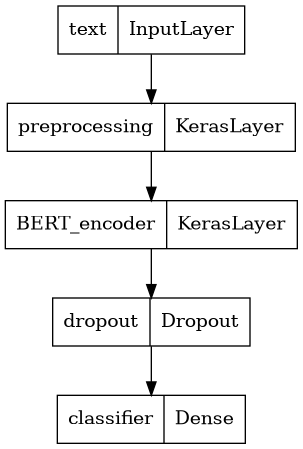

electra_base: https://github.com/google-research/electra

### Fine tuning pretrained model

In [30]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = X, y = y, validation_split=0.2, epochs=epochs, callbacks=[early_stop_callback])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
191/191 [==============================] - 95s 460ms/step - loss: 0.5211 - binary_accuracy: 0.7470 - val_loss: 0.4175 - val_binary_accuracy: 0.8056
Epoch 2/10
191/191 [==============================] - 88s 462ms/step - loss: 0.3832 - binary_accuracy: 0.8383 - val_loss: 0.4007 - val_binary_accuracy: 0.8214
Epoch 3/10
191/191 [==============================] - 89s 468ms/step - loss: 0.3390 - binary_accuracy: 0.8614 - val_loss: 0.4083 - val_binary_accuracy: 0.8221
Epoch 4/10
191/191 [==============================] - 89s 468ms/step - loss: 0.3295 - binary_accuracy: 0.8650 - val_loss: 0.4083 - val_binary_accuracy: 0.8221


##### Training and validation loss wrt epochs

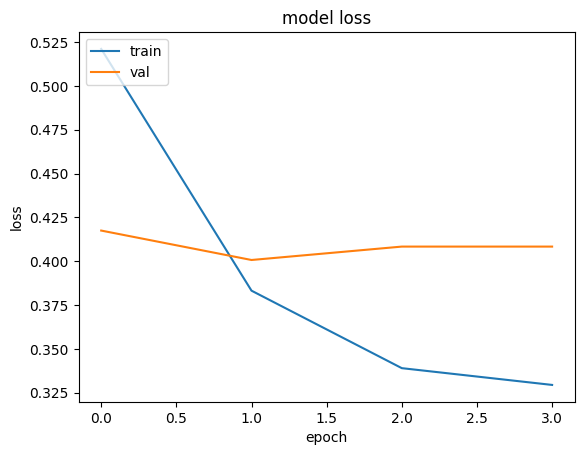

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### Experimenting with threshold

In [32]:
y_pred = classifier_model.predict(X)

238/238 [==============================] - 40s 168ms/step


In [33]:
threshold_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
f1_score_list = []
for threshold in threshold_list:
    y_pred_bool = [1 if x[0] >= threshold else 0 for x in y_pred]
    f1_score_list.append({"threshold": threshold, "f1": f1_score(y, y_pred_bool), "accuracy": accuracy_score(y, y_pred_bool)})

pd.DataFrame(f1_score_list)


,threshold,f1,accuracy
0,0.1,0.747300,0.720347
1,0.2,0.805414,0.809274
2,0.3,0.826701,0.842112
3,0.4,0.841200,0.861684
4,0.5,0.842319,0.867464
5,0.6,0.840323,0.869959
6,0.7,0.833916,0.869040
7,0.8,0.812262,0.857612
8,0.9,0.767305,0.833968


In [ ]:
# creating submission csv
submission_data = pd.read_csv("data/test.csv")
pred = classifier_model.predict(np.array(remove_links_from_list(list(submission_data["text"]))))
submission_target = [1 if x[0]>0.6 else 0 for x in pred]
submission = pd.DataFrame({"id":list(submission_data["id"]), "target":submission_target})
submission.to_csv("submissions/submission.csv", index=False)

#### Result and Conclusion

- Acheived 0.83021 F1 score on test set.
- Preprocessing (ie removing # or links) didn't provide any performance gains.
- Adding hidden layers after the pre-trained model didn't improve performance; a single neuron proved most effective.
- Increasing dropout rates didn't lead to any performance gains.
- Implementing early stopping was vital in preventing overfitting and improving generalization.
- Fine-tuning the prediction threshold was necessary to accurately classify true disaster tweets.

- For future improvements, I could try bigger pretrained models namely llama, gemma etc.